In [2]:
from plot_helpers import *
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats 
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
from scipy.stats import linregress
import seaborn as sns
import matplotlib as mpl
# Set global font sizes - for manuscript
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.labelsize'] = 28
mpl.rcParams['xtick.labelsize'] = 24
mpl.rcParams['ytick.labelsize'] = 24
mpl.rcParams['legend.fontsize'] = 18




In [3]:
# Load the statistics CSV file
combined_statistics_path = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_combined_statistics.csv"
df = pd.read_csv(combined_statistics_path)

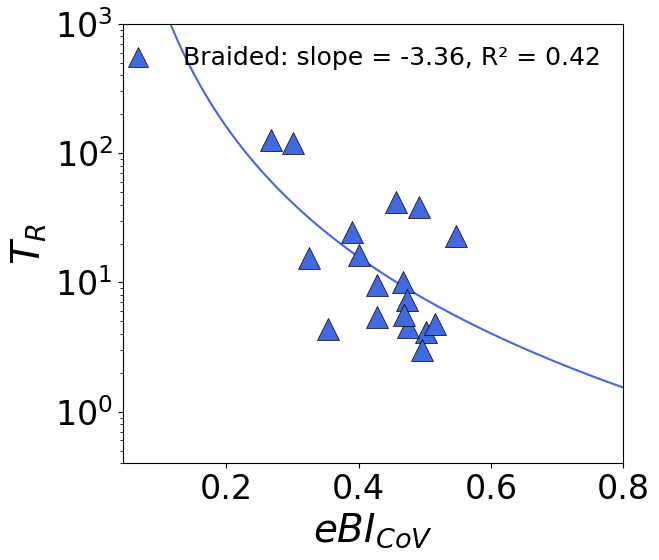

In [9]:
# Dynamically calculate x_range based on data (with padding)
x_range = (df['cov_ebi_site'].min() * 0.4, df['cov_ebi_site'].max() * 1.1)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Define markers and colors (braided group only)
markers = {'B': '^'}
colors = {'B': '#4169E1'}

# For this plot, we only use the 'B' (Braided) group.
# (Ensure that df['Group'] has already been defined appropriately.)
if 'Group' not in df.columns:
    df['Group'] = df['Classification']  # or use your appropriate grouping

# Dictionary to store slope and R² info for the legend
legend_info = {}

# Loop through the braided group to compute and plot the regression line.
for group in ['B']:
    subset = df[df['Group'] == group]
    x_data = subset['cov_ebi_site']
    y_data = subset['T_R']
    
    # Ensure x_data are positive (needed for log transformation)
    if any(x_data <= 0):
        raise ValueError(f"Group {group} contains non-positive x values, cannot use log transformation.")
    
    # Fit regression using the unified function with mode "log-x" (i.e. y = m*log(x) + b)
    slope, intercept, predict = fit_regression(x_data, y_data, mode="log-log")
    
    # Generate regression line values over the full x_range.
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = predict(x_line)
    
    # Plot the regression line.
    ax.plot(x_line, y_line, color=colors[group], lw=1.5)
    
    # Compute R² on the original data.
    y_pred = predict(x_data)
    ss_res = ((y_data - y_pred) ** 2).sum()
    ss_tot = ((y_data - y_data.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    
    # Store slope and R² information for the legend.
    legend_info[group] = f"slope = {slope:.2f}, R² = {r2:.2f}"

# Plot data points with error bars (if desired).
for group in ['B']:
    subset = df[df['Group'] == group]
    x_data = subset['cov_ebi_site']
    y_data = subset['T_R']
    
    
    ax.scatter(x_data, y_data, label=group, marker=markers[group],
               c=colors[group], edgecolors='black', s=250, alpha=1, zorder=2, linewidths=0.5)

# Set x-axis to log scale and adjust limits.
ax.set_yscale('log')
#ax.set_xscale('log')

ax.set_xlim(right=0.8)
ax.set_ylim(0.4,1e3)
# Set labels and tick parameters.
ax.set_ylabel(r'$T_R$')
ax.set_xlabel(r'${eBI_{CoV}}$')
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Create a legend with slope and R² information.
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: {legend_info['B']}",
           markerfacecolor=colors['B'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\10_eBI_cov_TR_B.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)


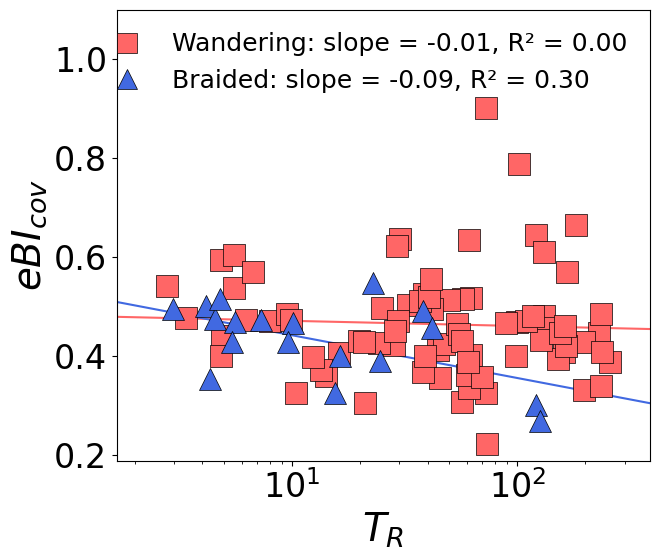

In [83]:
# Dynamically calculate x_range based on data (with padding)
x_range = (df['T_R'].min() * 0.6, df['T_R'].max() * 1.5)


# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Dictionary to store slope and R² info for the legend
legend_info = {}

# Loop through each group to compute and plot the regression line.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    y_data = subset['cov_ebi_site']
    x_data = subset['T_R']
    
    # Ensure x_data are positive (needed for log transformation)
    if any(x_data <= 0):
        raise ValueError(f"Group {group} contains non-positive x values, cannot use log transformation.")
    
    # Fit regression using the unified function with mode "log-x"
    slope, intercept, predict = fit_regression(x_data, y_data, mode="log-x")
    
    # Generate regression line values over the full x_range
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = predict(x_line)
    
    # Plot the regression line
    ax.plot(x_line, y_line, color=colors[group], lw=1.5)
    
    # Compute R² on the original data
    y_pred = predict(x_data)
    ss_res = ((y_data - y_pred) ** 2).sum()
    ss_tot = ((y_data - y_data.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    
    # Store slope and R² information for the legend
    legend_info[group] = f"slope = {slope:.2f}, R² = {r2:.2f}"

# Plot data points with error bars
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    y_data = subset['cov_ebi_site']
    x_data = subset['T_R']

    ax.scatter(x_data, y_data, label=group, marker=markers[group],
               c=colors[group], edgecolors='black', s=250, alpha=1, zorder=2, linewidths=0.5)

# Set x-axis to log scale and adjust limits
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(*x_range)
ax.set_ylim(top=1.1)

# Set labels and tick parameters
ax.set_xlabel(r'${T_{R}}$')  # Display fraction as LaTeX
ax.set_ylabel(r'${eBI_{cov}}$')
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Create a legend with slope and R² information
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: {legend_info['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: {legend_info['B']}",
           markerfacecolor=colors['B'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\10_eBI_cov_TR.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)

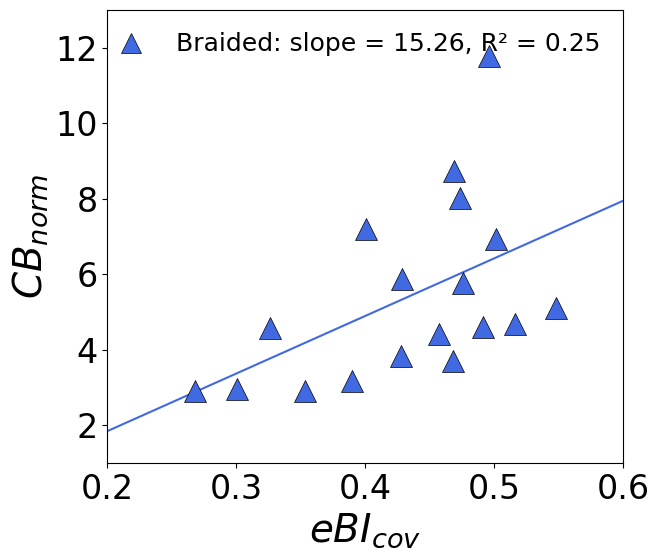

In [27]:
# Dynamically calculate x_range based on data (with padding)
x_range = (df['cov_ebi_site'].min() * 0.3, df['cov_ebi_site'].max() * 1.1)

# Define colors, markers
markers = {'B': '^'}
colors = {'B': '#4169E1'}

# Combine wandering classifications into one group (not needed if we only want B)
# wandering_types = ['HSW', 'LSW']
# df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')
# Or we can simply keep the user classification as "B" for braided only:

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Dictionary to store slope and R² info for the legend
legend_info = {}

# Filter the DataFrame to keep only braided rivers
subset_braided = df[df['Classification'] == 'B'].copy()

# -------------------------
# 1) Regression line for B
# -------------------------
x_data = subset_braided['cov_ebi_site']
y_data = subset_braided['CB/Aw']

# Ensure x_data are positive (needed for log transformation)
if any(x_data <= 0):
    raise ValueError("Group B contains non-positive x values, cannot use log transformation.")

# Fit regression using the unified function with mode="log-x"
slope, intercept, predict = fit_regression(x_data, y_data, mode="linear")

# Generate regression line values over the full x_range
x_line = np.linspace(x_range[0], x_range[1], 300)
y_line = predict(x_line)

# Plot the regression line
ax.plot(x_line, y_line, color=colors['B'], lw=1.5)

# Compute R² on the original data
y_pred = predict(x_data)
ss_res = ((y_data - y_pred) ** 2).sum()
ss_tot = ((y_data - y_data.mean()) ** 2).sum()
r2 = 1 - ss_res / ss_tot

legend_info['B'] = f"slope = {slope:.2f}, R² = {r2:.2f}"

# -------------------------
# 2) Scatter plot for B
# -------------------------
ax.scatter(
    x_data, y_data,
    label='Braided',
    marker=markers['B'],
    c=colors['B'],
    edgecolors='black',
    s=250,
    alpha=1,
    zorder=2,
    linewidths=0.5
)

# Set x-axis to log scale and adjust limits
#ax.set_xscale('log')
ax.set_ylim(1, 13)
ax.set_xlim(0.2, 0.6)

# Set labels and tick parameters
ax.set_ylabel(r'${CB_{norm}}$')
ax.set_xlabel(r'${eBI_{cov}}$')
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Create a legend with slope and R² for braided only
legend_elements = [
    Line2D(
        [0], [0],
        marker=markers['B'],
        color='w',
        label=f"Braided: {legend_info['B']}",
        markerfacecolor=colors['B'],
        markersize=15,
        markeredgecolor='black',
        markeredgewidth=0.5,
        linestyle='None'
    )
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()
fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\10_eBI_vs_CB.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)


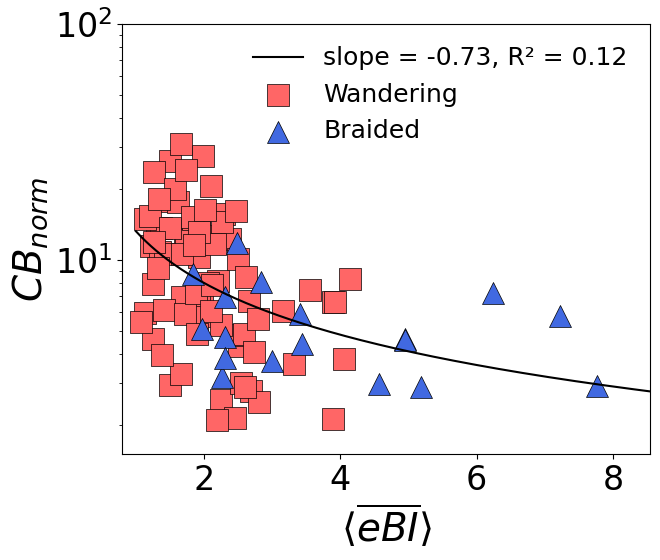

In [36]:
# Group classifications: combine wandering types
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Define combined x and y data
combined_x_data = df['mean_ebi_site']
combined_y_data = df['CB/Aw']

# Dynamically calculate x_range (with 10% padding)
x_range = (0, combined_x_data.max() * 1.1)

# --- Fit Combined Regression using mode "log-log" ---
slope, intercept, predict = fit_regression(combined_x_data, combined_y_data, mode="log-log")

# Generate x-values spanning x_range so the regression line fills the x-axis.
x_line = np.linspace(1, x_range[1], 300)
y_line = predict(x_line)

# Compute R² on the filtered data.
finite_mask = (combined_x_data > 0) & np.isfinite(combined_x_data) & np.isfinite(combined_y_data)
x_filt = combined_x_data[finite_mask]
y_filt = combined_y_data[finite_mask]
y_pred = predict(x_filt)
ss_res = np.sum((y_filt - y_pred)**2)
ss_tot = np.sum((y_filt - np.mean(y_filt))**2)
r2 = 1 - ss_res / ss_tot
legend_label = f"slope = {slope:.2f}, R² = {r2:.2f}"

# --- Create the Figure and Plot ---
fig, ax = plt.subplots(figsize=(7, 6))

# Plot the combined regression line.
ax.plot(x_line, y_line, color='black', lw=1.5, label=f"{legend_label}", zorder=3)

# Define markers and colors for groups.
markers = {'Wandering': 's', 'B': '^'}
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Ensure group assignment exists.
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Plot data points for each group.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['mean_ebi_site']
    y_data = subset['CB/Aw']
    label = "Wandering" if group == "Wandering" else "Braided"
    ax.scatter(x_data, y_data, label=label, marker=markers[group],
               c=colors[group], edgecolors='black', s=250, alpha=1, zorder=2, linewidths=0.5)

# Set x-axis limits.
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(*x_range)
ax.set_xlim(left=0.8)
ax.set_ylim(top=1e2, bottom=1.5)

# Set labels and tick parameters.
ax.set_xlabel(r'$\langle\overline{\mathit{eBI}}\rangle$')
ax.set_ylabel(r'${CB_{norm}}$')  
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Create a legend.
ax.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\10_ebi_cb.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)


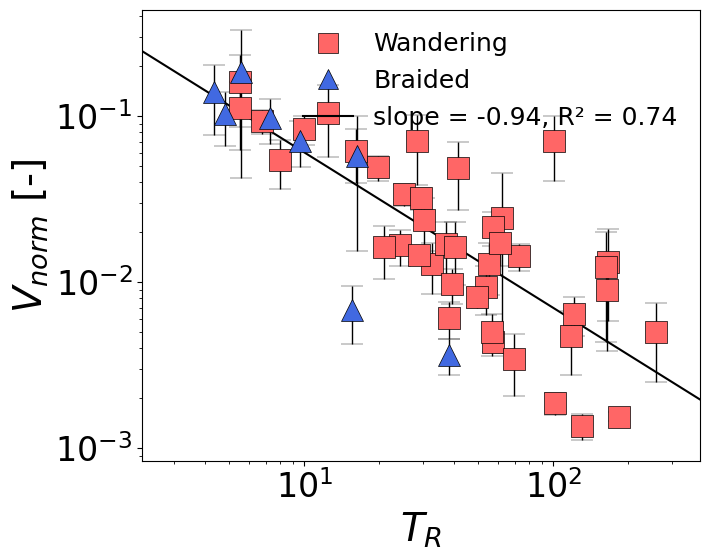

In [38]:
# Dynamically calculate x_range (with padding) using T_R.
x_range = (df['T_R'].min() * 0.8, df['T_R'].max() * 1.5)

# --- Fit Combined Regression ---
# Use T_R as x and norm_migration_rate as y.
slope, intercept, predict = fit_regression(df['T_R'], df['norm_migration_rate'], mode="log-log")

# Generate x-values for the regression line over the x_range.
line_x = np.linspace(x_range[0], x_range[1], 100)
line_y = predict(line_x)

# Compute R² on the filtered data.
finite_mask = (df['T_R'] > 0) & np.isfinite(df['T_R']) & np.isfinite(df['norm_migration_rate'])
x_filtered = df['T_R'][finite_mask]
y_filtered = df['norm_migration_rate'][finite_mask]
y_pred = predict(x_filtered)
ss_res = np.sum((y_filtered - y_pred) ** 2)
ss_tot = np.sum((y_filtered - np.mean(y_filtered)) ** 2)
r2 = 1 - ss_res / ss_tot

legend_label = f"slope = {slope:.2f}, R² = {r2:.2f}"

# --- Create the Plot ---
fig, ax = plt.subplots(figsize=(7.5, 6))

# Plot the regression line.
ax.plot(line_x, line_y, color='black', lw=1.5, label=legend_label)

# Define markers and colors for groups.
markers = {'Wandering': 's', 'B': '^'}
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group.
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Plot error bars and data points for each group.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['T_R']
    y_data = subset['norm_migration_rate']
    y_err = subset['norm_error']
    # Plot error bars.
    ax.errorbar(x_data, y_data, yerr=y_err, fmt='none', ecolor='black',
                capsize=8, alpha=1, zorder=1,capthick=0.3, elinewidth=1)
    # Plot scatter points.
    ax.scatter(x_data, y_data, label=("Wandering" if group == "Wandering" else "Braided"),
               marker=markers[group], c=colors[group], edgecolors='black',
               s=250, alpha=1, zorder=2, linewidths=0.5)

# Set both axes to log scale.
ax.set_xscale('log')
ax.set_xlim(*x_range)
ax.set_yscale('log')

ax.set_xlabel(r'$T_R$')
ax.set_ylabel(r'${V_{norm}}$ [-]')  # Display fraction as LaTeX
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Create custom legend.
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label="Wandering", markerfacecolor=colors['Wandering'],
           markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label="Braided", markerfacecolor=colors['B'],
           markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
    Line2D([0], [0], color='black', lw=1.5, label=legend_label)
]
ax.legend(handles=legend_elements,loc='upper right', frameon=False)

plt.tight_layout()
plt.show()


fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\10_Tr_vs_Migration_rate.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)

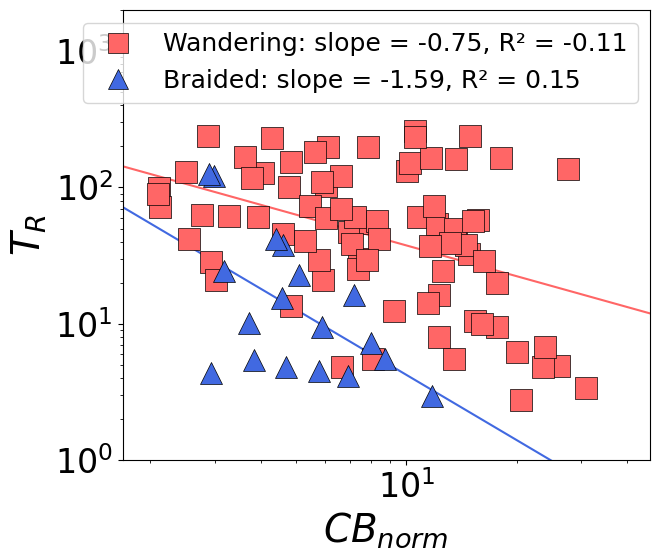

In [4]:
# Dynamically calculate x_range based on data (with padding)
x_range = (df['CB/Aw'].min() * 0.8, df['CB/Aw'].max() * 1.5)

# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Dictionary to store slope and R² info for the legend
legend_info = {}

# Loop through each group to compute and plot the regression line.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['CB/Aw']
    y_data = subset['T_R']
    
    # Ensure x_data are positive (needed for log transformation)
    if any(x_data <= 0):
        raise ValueError(f"Group {group} contains non-positive x values, cannot use log transformation.")
    
    # Fit regression using the unified function with mode "log-x"
    slope, intercept, predict = fit_regression(x_data, y_data, mode="log-log")
    
    # Generate regression line values over the full x_range
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = predict(x_line)
    
    # Plot the regression line
    ax.plot(x_line, y_line, color=colors[group], lw=1.5)
    
    # Compute R² on the original data
    y_pred = predict(x_data)
    ss_res = ((y_data - y_pred) ** 2).sum()
    ss_tot = ((y_data - y_data.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    
    # Store slope and R² information for the legend
    legend_info[group] = f"slope = {slope:.2f}, R² = {r2:.2f}"

# Plot data points with error bars
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['CB/Aw']
    y_data = subset['T_R']

    ax.scatter(x_data, y_data, label=group, marker=markers[group],
               c=colors[group], edgecolors='black', s=250, alpha=1, zorder=2, linewidths=0.5)

# Set x-axis to log scale and adjust limits
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(*x_range)
ax.set_ylim(bottom=1, top=2e3)

# Set labels and tick parameters
ax.set_xlabel(r'${CB_{norm}}$')  # Display fraction as LaTeX
ax.set_ylabel(r'${T_{R}}$')
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Create a legend with slope and R² information
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: {legend_info['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: {legend_info['B']}",
           markerfacecolor=colors['B'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\10_Tr_vs_CB.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)

### Supporting Information

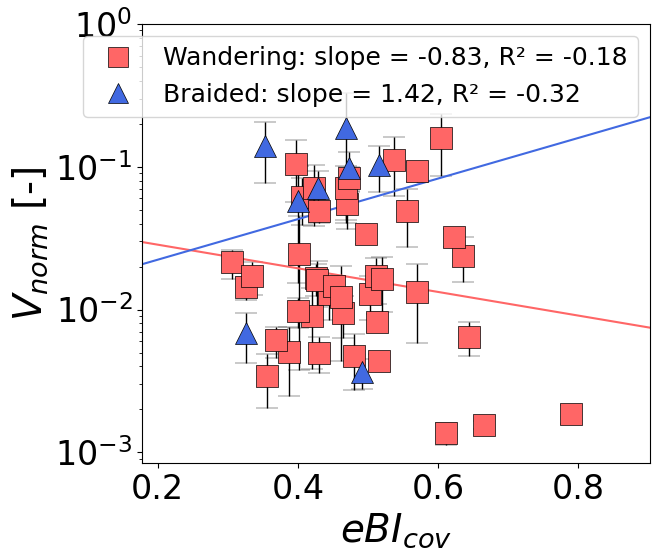

In [53]:
# Dynamically calculate x_range based on data (with padding)
x_range = (df['cov_ebi_site'].min() * 0.8, df['cov_ebi_site'].max() * 1)

# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Dictionary to store slope and R² info for the legend
legend_info = {}

# Loop through each group to compute and plot the regression line.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['cov_ebi_site']
    y_data = subset['norm_migration_rate']
    
      # Ensure x_data are positive (needed for log transformation)
    if any(x_data <= 0):
        raise ValueError(f"Group {group} contains non-positive x values, cannot use log transformation.")
    
    # Fit regression using the unified function with mode "log-x"
    slope, intercept, predict = fit_regression(x_data, y_data, mode="log-y")
    
    # Generate regression line values over the full x_range
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = predict(x_line)

    # Plot the regression line
    ax.plot(x_line, y_line, color=colors[group], lw=1.5)
    
    # Compute R² on the original data
    y_pred = predict(x_data)
    ss_res = ((y_data - y_pred) ** 2).sum()
    ss_tot = ((y_data - y_data.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    
    # Store slope and R² information for the legend
    legend_info[group] = f"slope = {slope:.2f}, R² = {r2:.2f}"

for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['cov_ebi_site']
    y_data = subset['norm_migration_rate']
    y_error = subset['norm_error'] 
    
    # Plot error bars.
    ax.errorbar(x_data, y_data, yerr=y_error, fmt='none', ecolor='black',
                capsize=8, alpha=1, zorder=1,capthick=0.3, elinewidth=1)

    ax.scatter(x_data, y_data, label=group, marker=markers[group],
               c=colors[group], edgecolors='black', s=250, alpha=1, zorder=2, linewidths=0.5)

# Set x-axis to log scale and adjust limits
ax.set_yscale('log')
ax.set_xlim(*x_range)
ax.set_ylim(top=1)

# Set labels and tick parameters
ax.set_xlabel(r'${eBI_{cov}}$')
ax.set_ylabel(r'${V_{norm}}$ [-]')  # Display fraction as LaTeX
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Create a legend with slope and R² information
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: {legend_info['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: {legend_info['B']}",
           markerfacecolor=colors['B'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\supp_V_ebi_cov.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)

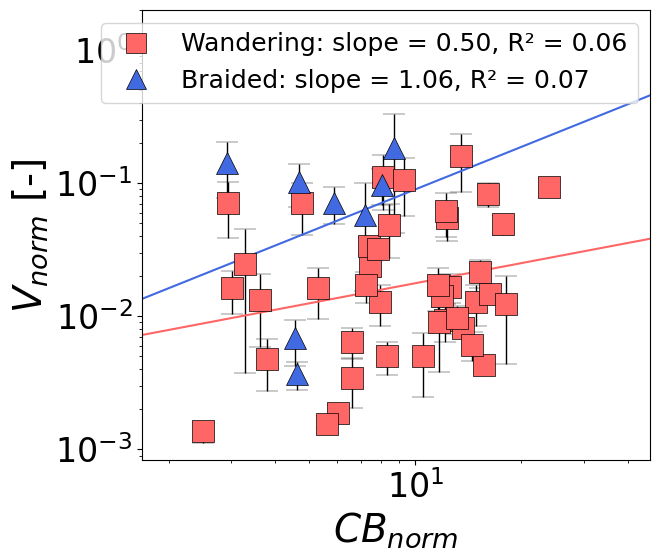

In [12]:
# Dynamically calculate x_range based on data (with padding)
x_range = (df['CB/Aw'].min() * 0.8, df['CB/Aw'].max() * 1.5)

# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Dictionary to store slope and R² info for the legend
legend_info = {}

# Loop through each group to compute and plot the regression line.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['CB/Aw']
    y_data = subset['norm_migration_rate']
    
      # Ensure x_data are positive (needed for log transformation)
    if any(x_data <= 0):
        raise ValueError(f"Group {group} contains non-positive x values, cannot use log transformation.")
    
    # Fit regression using the unified function in log-log mode and get R².
    slope, intercept, predict, r2 = fit_regression(x_data, y_data, mode="log-log", return_r2=True)
    
    # Generate regression line values over the full x_range.
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = predict(x_line)
    
    # Plot the regression line.
    ax.plot(x_line, y_line, color=colors[group], lw=1.5)
    
    # Store slope and R² information for the legend.
    legend_info[group] = f"slope = {slope:.2f}, R² = {r2:.2f}"

# Plot data points with error bars
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['CB/Aw']
    y_data = subset['norm_migration_rate']
    y_error = subset['norm_error'] 
    
    # Plot error bars.
    ax.errorbar(x_data, y_data, yerr=y_error, fmt='none', ecolor='black',
                capsize=8, alpha=1, zorder=1,capthick=0.3, elinewidth=1)

    ax.scatter(x_data, y_data, label=group, marker=markers[group],
               c=colors[group], edgecolors='black', s=250, alpha=1, zorder=2, linewidths=0.5)

# Set x-axis to log scale and adjust limits
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(*x_range)
ax.set_ylim(top=2)

# Set labels and tick parameters
ax.set_xlabel(r'${CB_{norm}}$')  # Display fraction as LaTeX
ax.set_ylabel(r'${V_{norm}}$ [-]')  # Display fraction as LaTeX
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Create a legend with slope and R² information
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: {legend_info['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: {legend_info['B']}",
           markerfacecolor=colors['B'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\supp_CB_Migration.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)

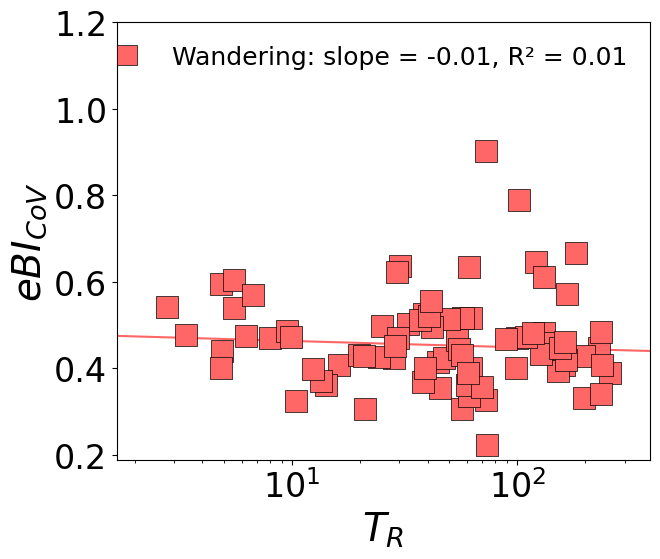

In [42]:
# Dynamically calculate x_range based on data (with padding)
x_range = (df['T_R'].min() * 0.6, df['T_R'].max() * 1.5)

# Assume your unified regression function (from common.py) is available:
# def fit_regression(x, y, mode="log-x"):
#     <function body that filters data, uses np.polyfit on np.log(x), and returns slope, intercept, predict>

# Define markers and colors for Wandering rivers
markers = {'Wandering': 's'}
colors = {'Wandering': '#FF6666'}

# Combine HSW and LSW as "Wandering"
df['Group'] = df['Classification'].apply(lambda x: 'Wandering' if x in ['HSW', 'LSW'] else x)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Dictionary to store slope and R² info for the legend
legend_info = {}

# Loop through the Wandering group to compute and plot the regression line.
for group in ['Wandering']:
    subset = df[df['Group'] == group]
    x_data = subset['T_R']
    y_data = subset['cov_ebi_site']
    
    # Ensure x_data are positive (needed for log transformation)
    if any(x_data <= 0):
        raise ValueError(f"Group {group} contains non-positive x values, cannot use log transformation.")
    
    
    # Fit regression using the unified function in log-log mode and get R².
    slope, intercept, predict, r2 = fit_regression(x_data, y_data, mode="log-log", return_r2=True)
    
    # Generate regression line values over the full x_range.
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = predict(x_line)
    
    # Plot the regression line.
    ax.plot(x_line, y_line, color=colors[group], lw=1.5)
    
    # Store slope and R² information for the legend.
    legend_info[group] = f"slope = {slope:.2f}, R² = {r2:.2f}"


# Plot data points (with error bars if desired)
for group in ['Wandering']:
    subset = df[df['Group'] == group]
    x_data = subset['T_R']
    y_data = subset['cov_ebi_site']
    # error_data = subset['ebi_error_annual']
    
    # Optionally, add error bars:
    # ax.errorbar(x_data, y_data, yerr=error_data, fmt='none', ecolor='black', elinewidth=2, capsize=5, zorder=1)
    
    ax.scatter(x_data, y_data, label=group, marker=markers[group],
               c=colors[group], edgecolors='black', s=250, alpha=1, zorder=2, linewidths=0.5)

# Set x-axis to log scale and adjust limits
ax.set_xscale('log')
ax.set_xlim(*x_range)
ax.set_ylim(top=1.2)

# Set labels and tick parameters
ax.set_xlabel(r'$T_R$')
ax.set_ylabel(r'${eBI_{CoV}}$')
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Create a legend with slope and R² information
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: {legend_info['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\7_eBI_cov_TR_W.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)

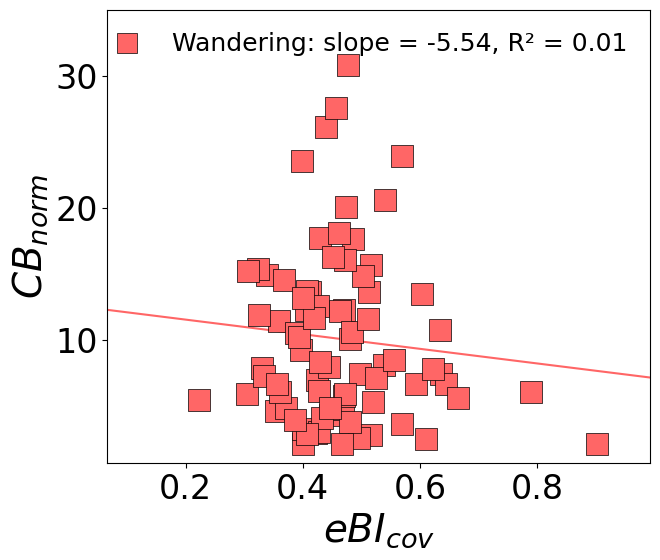

In [21]:
# Dynamically calculate x_range based on data (with padding)
x_range = (df['cov_ebi_site'].min() * 0.3, df['cov_ebi_site'].max() * 1.1)

# Define colors, markers for wandering
markers = {'Wandering': 's'}
colors = {'Wandering': '#FF6666'}

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Dictionary to store slope and R² info for the legend
legend_info = {}

# Filter the DataFrame to keep only wandering rivers
subset_wand = df[df['Classification'].isin(['HSW', 'LSW'])].copy()

# -------------------------
# 1) Regression line for Wandering
# -------------------------
x_data = subset_wand['cov_ebi_site']
y_data = subset_wand['CB/Aw']

# Ensure x_data are positive (needed for regression)
if any(x_data <= 0):
    raise ValueError("Wandering group contains non-positive x values, cannot proceed.")

# Fit regression using the unified function with mode="linear"
slope, intercept, predict = fit_regression(x_data, y_data, mode="linear")

# Generate regression line values over the full x_range
x_line = np.linspace(x_range[0], x_range[1], 300)
y_line = predict(x_line)

# Plot the regression line
ax.plot(x_line, y_line, color=colors['Wandering'], lw=1.5)

# Compute R² on the original data
y_pred = predict(x_data)
ss_res = ((y_data - y_pred) ** 2).sum()
ss_tot = ((y_data - y_data.mean()) ** 2).sum()
r2 = 1 - ss_res / ss_tot

legend_info['Wandering'] = f"slope = {slope:.2f}, R² = {r2:.2f}"

# -------------------------
# 2) Scatter plot for Wandering
# -------------------------
ax.scatter(
    x_data, y_data,
    label='Wandering',
    marker=markers['Wandering'],
    c=colors['Wandering'],
    edgecolors='black',
    s=250,
    alpha=1,
    zorder=2,
    linewidths=0.5
)

# Set axis limits
ax.set_xlim(x_range)
ax.set_ylim(top=35)

# Set labels and tick parameters
ax.set_xlabel(r'${eBI_{cov}}$')
ax.set_ylabel(r'${CB_{norm}}$')
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Create a legend with slope and R² for wandering only
legend_elements = [
    Line2D(
        [0], [0],
        marker=markers['Wandering'],
        color='w',
        label=f"Wandering: {legend_info['Wandering']}",
        markerfacecolor=colors['Wandering'],
        markersize=15,
        markeredgecolor='black',
        markeredgewidth=0.5,
        linestyle='None'
    )
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()


fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\supp_eBI_cov_CB_W.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)